# GHI Forecast

In [1]:
# Imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')


In [2]:
solar_data = pd.read_csv('data/solar/ottawa_nsrdb_2020.csv', skiprows=2)
solar_data.head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,GHI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Global Horizontal UV Irradiance (280-400nm),Global Horizontal UV Irradiance (295-385nm)
0,2020,1,1,0,30,-0.8,0,0,0,4,...,0,98.82,120.70,0.87,990,0.8,201,0.7,0.0,0.0
1,2020,1,1,1,30,-1.5,0,0,0,4,...,0,98.48,131.20,0.87,990,0.8,207,0.6,0.0,0.0
2,2020,1,1,2,30,-2.2,0,0,0,4,...,0,97.80,141.35,0.87,990,0.8,208,0.6,0.0,0.0
3,2020,1,1,3,30,-2.8,0,0,0,4,...,0,97.12,150.34,0.87,989,0.8,210,0.6,0.0,0.0
4,2020,1,1,4,30,-3.2,0,0,0,4,...,0,95.72,156.48,0.87,989,0.8,221,0.6,0.0,0.0


In [3]:
solar_data.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'Clearsky DHI',
       'Clearsky DNI', 'Clearsky GHI', 'Cloud Type', 'Dew Point', 'DHI', 'DNI',
       'Fill Flag', 'GHI', 'Relative Humidity', 'Solar Zenith Angle',
       'Surface Albedo', 'Pressure', 'Precipitable Water', 'Wind Direction',
       'Wind Speed', 'Global Horizontal UV Irradiance (280-400nm)',
       'Global Horizontal UV Irradiance (295-385nm)'],
      dtype='object')

In [4]:
solar_data['Timestamp'] = solar_data['Year'].astype(str) + '-' + solar_data['Month'].astype(str) + '-' + solar_data['Day'].astype(str) + ' ' + solar_data['Hour'].astype(str) + ':00'
solar_data.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'Clearsky DHI',
       'Clearsky DNI', 'Clearsky GHI', 'Cloud Type', 'Dew Point', 'DHI', 'DNI',
       'Fill Flag', 'GHI', 'Relative Humidity', 'Solar Zenith Angle',
       'Surface Albedo', 'Pressure', 'Precipitable Water', 'Wind Direction',
       'Wind Speed', 'Global Horizontal UV Irradiance (280-400nm)',
       'Global Horizontal UV Irradiance (295-385nm)', 'Timestamp'],
      dtype='object')

In [5]:
solar_data['Timestamp'] = pd.to_datetime(solar_data['Timestamp'], yearfirst=True)
solar_data = solar_data.set_index('Timestamp')
solar_data.index

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2020-12-31 14:00:00', '2020-12-31 15:00:00',
               '2020-12-31 16:00:00', '2020-12-31 17:00:00',
               '2020-12-31 18:00:00', '2020-12-31 19:00:00',
               '2020-12-31 20:00:00', '2020-12-31 21:00:00',
               '2020-12-31 22:00:00', '2020-12-31 23:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=8760, freq=None)

In [6]:
solar_data.resample('h')
solar_data_v2 = solar_data.interpolate(method="time")


In [7]:
solar_data.isna().sum()

Year                                           0
Month                                          0
Day                                            0
Hour                                           0
Minute                                         0
Temperature                                    0
Clearsky DHI                                   0
Clearsky DNI                                   0
Clearsky GHI                                   0
Cloud Type                                     0
Dew Point                                      0
DHI                                            0
DNI                                            0
Fill Flag                                      0
GHI                                            0
Relative Humidity                              0
Solar Zenith Angle                             0
Surface Albedo                                 0
Pressure                                       0
Precipitable Water                             0
Wind Direction      

In [8]:
features = ["GHI", "Temperature", "Relative Humidity", "DNI", "DHI", "Cloud Type"]
solar_data_v2 = solar_data[features].copy()

In [9]:
# Feature engineering
# Temporal Features
solar_data_v2["hour"] = solar_data_v2.index.hour
solar_data_v2["hour_sin"] = np.sin(2*np.pi*solar_data_v2["hour"]/24)
solar_data_v2["hour_cos"] = np.cos(2*np.pi*solar_data_v2["hour"]/24)
solar_data_v2.columns

Index(['GHI', 'Temperature', 'Relative Humidity', 'DNI', 'DHI', 'Cloud Type',
       'hour', 'hour_sin', 'hour_cos'],
      dtype='object')

In [10]:
df = solar_data_v2['2020-01':'2020-12-02 00:00:00']
train_data = solar_data_v2['2020-01':'2020-11']
train_data_y = train_data.GHI
test_data = solar_data_v2['2020-12-01':'2020-12-02 00:00:00']
test_data_y = test_data.GHI

In [11]:
train_data.index

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2020-11-30 14:00:00', '2020-11-30 15:00:00',
               '2020-11-30 16:00:00', '2020-11-30 17:00:00',
               '2020-11-30 18:00:00', '2020-11-30 19:00:00',
               '2020-11-30 20:00:00', '2020-11-30 21:00:00',
               '2020-11-30 22:00:00', '2020-11-30 23:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=8016, freq=None)

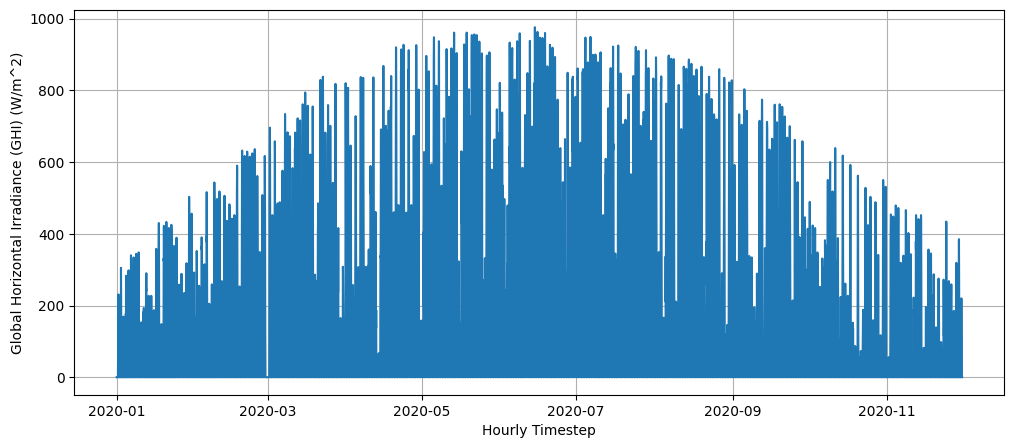

In [12]:
plt.figure(figsize=(12,5))
plt.plot(train_data.index, train_data.GHI)
plt.xlabel('Hourly Timestep')
plt.ylabel('Global Horizontal Irradiance (GHI) (W/m^2)')
plt.grid(True)
plt.show()

### Model Evaluation Function

In [13]:
def eval_forecast(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} MAE: {mae:.3f}  RMSE: {rmse:.3f}")
    return mae, rmse

## Baseline Model: ARIMA

In [14]:
train_data_ARIMA = train_data.GHI
test_data_ARIMA = test_data.GHI

In [15]:
# ARIMA(p,d,q) model with autoregressive order p (previous values), differencing dgree d, and q lagged error 
ARIMA_model = ARIMA(train_data_ARIMA, order=(2,1,2)) 
ARIMA_model = ARIMA_model.fit()

ARIMA_forecast = ARIMA_model.forecast(steps=len(test_data_ARIMA))

mae_arima, rmse_arima = eval_forecast(y_true=test_data_ARIMA, y_pred=ARIMA_forecast)

print("ARIMA MAE:", mae_arima)
print("ARIMA RMSE:", rmse_arima)


Model MAE: 62.842  RMSE: 72.600
ARIMA MAE: 62.84246925032316
ARIMA RMSE: 72.59951735754854


In [16]:
x = [i for i in range(len(test_data_ARIMA))]
print(x)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


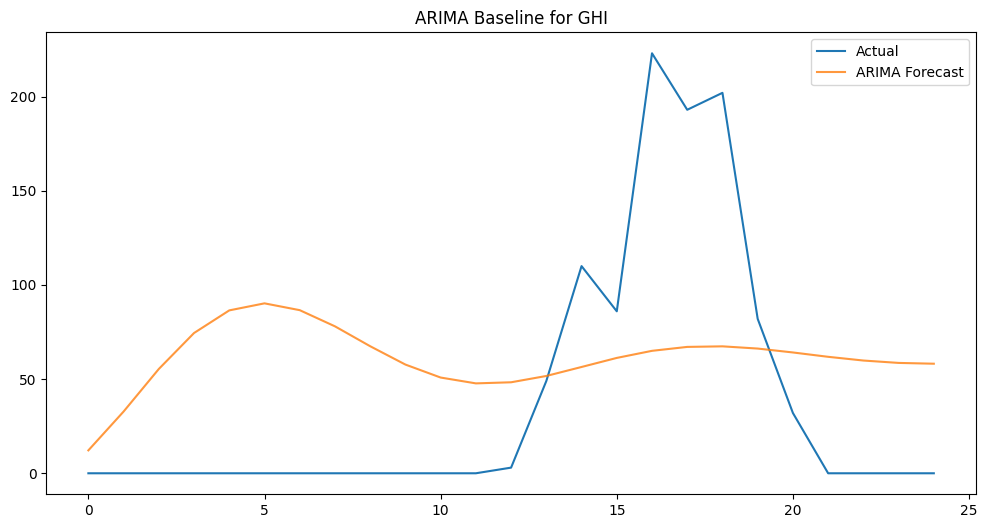

In [17]:
plt.figure(figsize=(12,6))
plt.plot(x, test_data_ARIMA, label="Actual")
plt.plot(x, ARIMA_forecast, label="ARIMA Forecast", alpha=0.8)
plt.legend()
plt.title("ARIMA Baseline for GHI")
plt.show()


## Baseline Model: SARIMA

In [18]:
SARIMA_model = SARIMAX(train_data_ARIMA, order=(2,1,2), seasonal_order=(1,1,1,24),
                    enforce_stationarity=False, enforce_invertibility=False)
SARIMA_model = SARIMA_model.fit(disp=False)

SARIMA_forecast = SARIMA_model.forecast(steps=len(test_data_ARIMA))

mae_sarima, rmse_sarima = eval_forecast(y_true=test_data_ARIMA, y_pred=SARIMA_forecast)

print("SARIMA MAE:", mae_sarima)
print("SARIMA RMSE:", rmse_sarima)

Model MAE: 25.620  RMSE: 39.709
SARIMA MAE: 25.62034837994402
SARIMA RMSE: 39.70854317743777


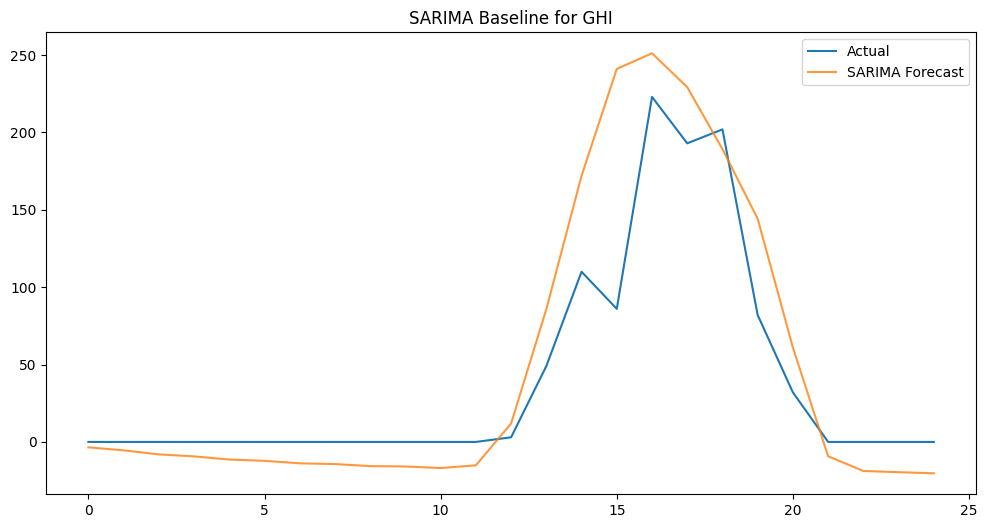

In [19]:
plt.figure(figsize=(12,6))
plt.plot(x, test_data_ARIMA, label="Actual")
plt.plot(x, SARIMA_forecast, label="SARIMA Forecast", alpha=0.8)
plt.legend()
plt.title("SARIMA Baseline for GHI")
plt.show()

## Machine Learning Model 1: RandomForestRegressor

In [20]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(train_data, train_data_y)
y_pred_rf = rf.predict(test_data)

mae_rf, rmse_rf = eval_forecast(y_true=test_data_y, y_pred=y_pred_rf)


Model MAE: 0.012  RMSE: 0.039


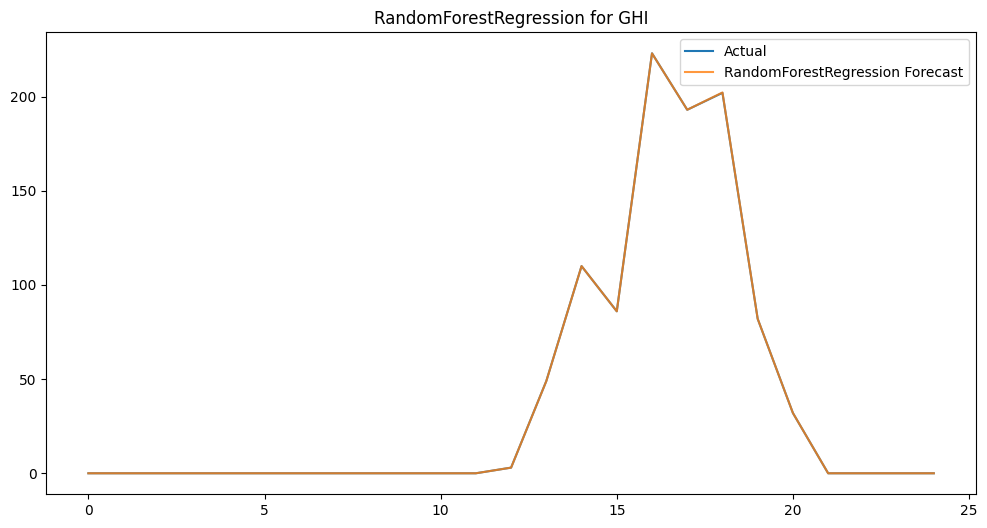

In [21]:
plt.figure(figsize=(12,6))
plt.plot(x, test_data_y, label="Actual")
plt.plot(x, y_pred_rf, label="RandomForestRegression Forecast", alpha=0.8)
plt.legend()
plt.title("RandomForestRegression for GHI")
plt.show()

## Deep Learning Model: LSTM

In [72]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

def create_sequences (data, target_col =0, seq_len=24):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len,:])
        y.append(data[i+seq_len, target_col])
    return np.array(X), np.array(y)

seq_len = 24
X, y = create_sequences(data=df_scaled, target_col=0, seq_len=seq_len)

X_train_lstm, X_test_lstm = X[:len(X)-seq_len], X[len(X)-seq_len:]
y_train_lstm, y_test_lstm = y[:len(y)-seq_len], y[len(y)-seq_len:]

In [73]:
import torch
import torch.nn as nn

In [74]:
# LSTM model
class LSTM_model(nn.Module):
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32, dropout=0.2):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_dim1, hidden_size=hidden_dim2, batch_first=True)
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(in_features=hidden_dim2, out_features=1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = self.dropout(out[:,-1,:]) # sequence to one
        out = self.fc(out)
        return out

input_dim = X_train_lstm.shape[2]
model = LSTM_model(input_dim=input_dim)
print(model)

LSTM_model(
  (lstm1): LSTM(9, 64, batch_first=True)
  (lstm2): LSTM(64, 32, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [75]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [76]:
X_train_lstm_t = torch.tensor(X_train_lstm, dtype=torch.float32)
y_train_lstm_t = torch.tensor(y_train_lstm, dtype=torch.float32).view(-1,1)
train_dataset = TensorDataset(X_train_lstm_t, y_train_lstm_t)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X_test_lstm_t = torch.tensor(X_test_lstm, dtype=torch.float32)
y_test_lstm_t = torch.tensor(y_test_lstm, dtype=torch.float32).view(-1,1)
test_dataset = TensorDataset(X_test_lstm_t, y_test_lstm_t)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
model.to(device=device)

LSTM_model(
  (lstm1): LSTM(9, 64, batch_first=True)
  (lstm2): LSTM(64, 32, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [77]:
epochs = 20
model_train_loss = []
for epoch in range(epochs):
    model.train()
    train_loss_per_epoch = []
    for X_batch, y_batch in train_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predicts = model(X_batch)
        loss = criterion(predicts, y_batch)
        loss.backward()
        optimizer.step()
        train_loss_per_epoch.append(loss.item())
    model_train_loss.append(np.mean(train_loss_per_epoch))

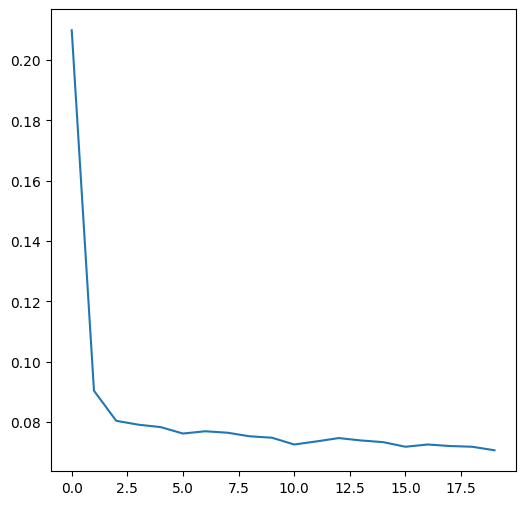

In [78]:
plt.figure(figsize=(6,6))
plt.plot(model_train_loss)
plt.show()

In [80]:
model.eval()
test_losses = []
with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        print("NaN in input:", torch.isnan(X_batch).any().item(),
          "NaN in target:", torch.isnan(y_batch).any().item())
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        print(X_batch.shape)
        test_losses.append(loss.item())

print(f"Test Loss={np.mean(test_losses):.4f}")



NaN in input: False NaN in target: False
torch.Size([24, 24, 9])
Test Loss=0.0133


In [95]:
index = [i for i in range(len(y_test_lstm))]
len(index)

24

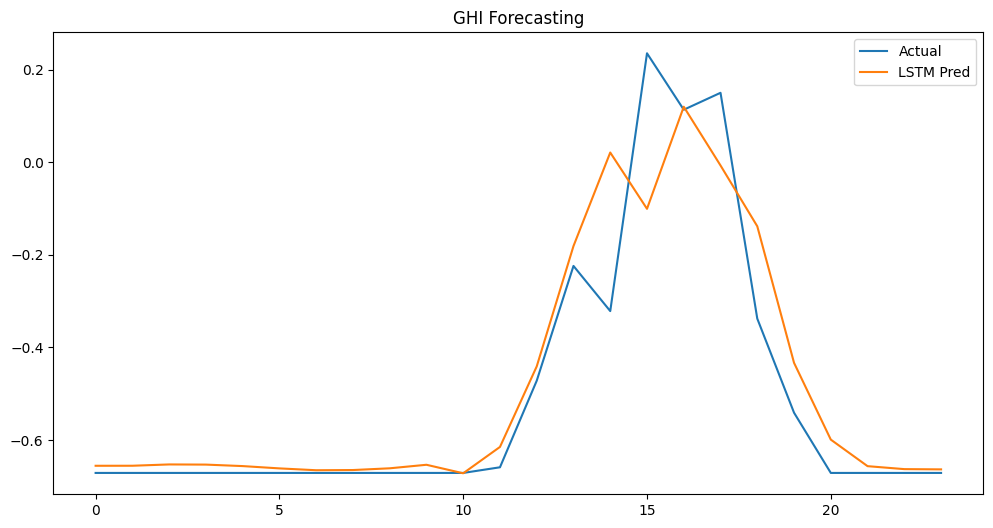

In [97]:

plt.figure(figsize=(12,6))
plt.plot(index, y_test_lstm, label="Actual")
plt.plot(index, y_pred.to('cpu'), label="LSTM Pred")
# plt.plot(test.index, y_pred_rf, label="RF Pred", alpha=0.6)
plt.legend()
plt.title("GHI Forecasting")
plt.show()
